In [1]:
using Plots

include("../src/Schemish.jl")
using .Schemish
using .Schemish: zeros

include("../src/AppendixA.jl")
using .AppendixA

# 1 - The Lines Sleep Tonight

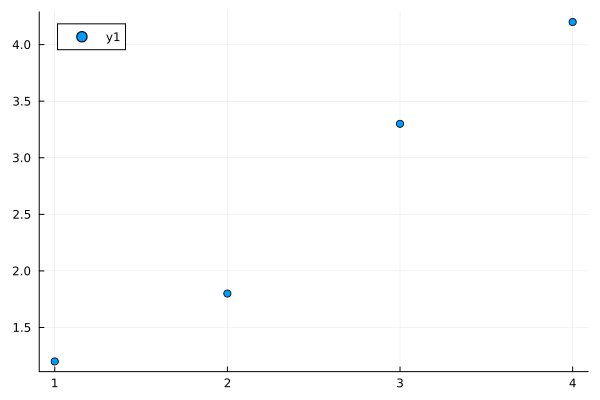

In [2]:
line_xs = tensor([2.0, 1.0, 4.0, 3.0])
line_ys = tensor([1.8, 1.2, 4.2, 3.3])

plot(line_xs.elements, line_ys.elements, seriestype=:scatter)

In [3]:

# frame 26:25

line(x) = (θ) -> ref(θ, 0) * x + ref(θ, 1)

line (generic function with 1 method)

In [4]:
line(5)(list(1, 2))

7

# 2 - The More We Learn, the Tenser We Become

In [5]:
@assert is_scalar(9)
@assert is_scalar(3.1415)
@assert !is_scalar(tensor([1]))
@assert tlen(tensor([17, 12, 91, 67])) == 4
@assert tlen(tensor([[3, 2, 8], [7, 1, 9]])) == 2

In [6]:

# frame 39:37

function shape(t)
    result = list()
    while !is_scalar(t)
        # the iterative implementation requires us to append to the list,
        # in contrast to the book's recursive implementation that prepends.
        result = snoc(result, tlen(t))
        t = tref(t, 0)
    end
    result
end

shape (generic function with 1 method)

In [7]:
@assert shape(9) == list()
@assert shape(tensor([9, 4, 7, 8, 0, 1])) == list(6)
@assert shape(tensor([[[5], [6], [8]], [[7], [9], [5]]])) == list(2, 3, 1)

In [8]:

# frame 42:44

function rank(t)
    result = 0
    while !is_scalar(t)
        # this is mostly equivalent to the books accumulator passing style;
        # we just mutate the accumulator in place.
        result += 1
        t = tref(t, 0)
    end
    result
end

rank (generic function with 1 method)

In [9]:
@assert rank(9) == 0
@assert rank(tensor([9, 4, 7, 8, 0, 1])) == 1
@assert rank(tensor([[[5], [6], [8]], [[7], [9], [5]]])) == 3

# Interlude I - The More We Extend, the Less Tensor We Get

In [10]:
@assert tensor([5, 6, 7]) + tensor([2, 0, 1]) == tensor([7, 6, 8])
@assert 4 + tensor([3, 6, 5]) == tensor([7, 10, 9])
@assert tensor([6, 9, 1]) + tensor([[4, 3, 8], [7, 4, 7]]) == tensor([[10, 12, 9], [13, 13, 8]])
@assert tensor([[4, 6, 5], [6, 9, 7]]) * 3 == tensor([[12, 18, 15], [18, 27, 21]])

@assert sqrt(tensor([9, 16, 25])) == tensor([3, 4, 5])
@assert sqrt(tensor([[49, 81, 16], [64, 25, 36]])) == tensor([[7, 9, 4], [8, 5, 6]])

In [11]:

# frame 53:24

function sum_1(t)
    result = 0
    for i in 0:tlen(t)-1
        result = result + tref(t, i)
    end
    result
end

sum = ext1(sum_1, 1)

(::Main.Schemish.var"#extended#10"{typeof(sum_1), Int64}) (generic function with 1 method)

In [12]:
@assert sum_1(tensor([10.0, 12.0, 14.0])) == 36.0
@assert sum(tensor([[[1, 2], [3, 4]], [[5, 6], [7, 8]]])) == tensor([[3, 7], [11, 15]])

In [13]:
line(tensor([2, 7, 5, 11]))(list(4, 6))

[14 34 26 50]

# 3 - Running Down a Slippery Slope

In [14]:

# frame 63:22

l2_loss(target) = (xs, ys) -> (θ) -> sum(sqr(ys - target(xs)(θ)))

l2_loss (generic function with 1 method)

In [15]:
expectant = l2_loss(line)
objective = expectant(line_xs, line_ys)
loss_0 = objective(list(0.0, 0.0))

33.21

In [16]:
loss_0_ = objective(list(0.0099, 0.0))
rate_of_change = (loss_0_ - loss_0) / 0.0099
θ0_1 = 0.0 - rate_of_change * 0.01
loss_1 = objective(list(θ0_1, 0.0))

5.502108626999984

In [17]:
loss_1_ = objective(list(θ0_1 + 0.0099, 0.0))
rate_of_change = (loss_1_ - loss_1) / 0.0099

-25.08119999999999

As we see, the rate of change depends on the current θ...

# 4 - Slip-slidin' Away

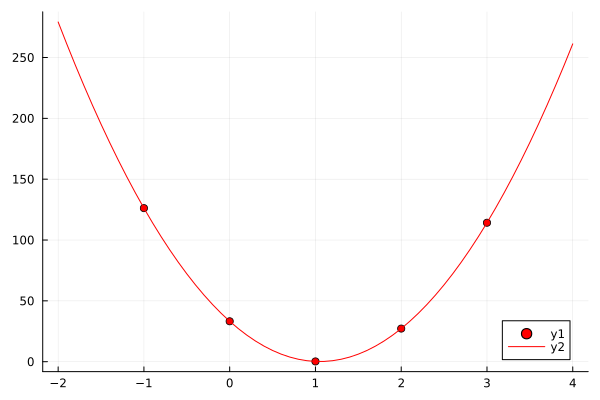

In [18]:
let θ0s = [-1, 0, 1, 2, 3]
    let losses = [objective(list(θ0, 0.0)) for θ0 in θ0s]
        plot(θ0s, losses, seriestype=:scatter, color=:red)
    end
end

let θ0s = -2:0.1:4
    let losses = [objective(list(θ0, 0.0)) for θ0 in θ0s]
        plot!(θ0s, losses, color=:red)
    end
end

In [19]:
@assert gradient_of((θ) -> sqr(ref(θ, 0)), list(27)) == list(54)

In [20]:
@assert gradient_of(objective, list(0.0, 0.0)) == list(-63.0, -21.0)

In [21]:

# frame 80:24

function revise(f, revs, θ)
    for _ in 1:revs
        θ = f(θ)
    end
    return θ
end

revise (generic function with 1 method)

In [22]:
@assert revise((θ) -> map((p) -> p - 3, θ), 5, list(1, 2, 3)) == list(-14, -13, -12)

In [23]:
θ = let α = 0.01, obj = l2_loss(line)(line_xs, line_ys)
    function f(θ)
        gs = ∇(obj, θ)
        list(ref(θ, 0) - α * ref(gs, 0),
            ref(θ, 1) - α * ref(gs, 1))
    end
    revise(f, 1000, list(0.0, 0.0))
end


(1.0499993623489503, 1.8747718457656533e-6)

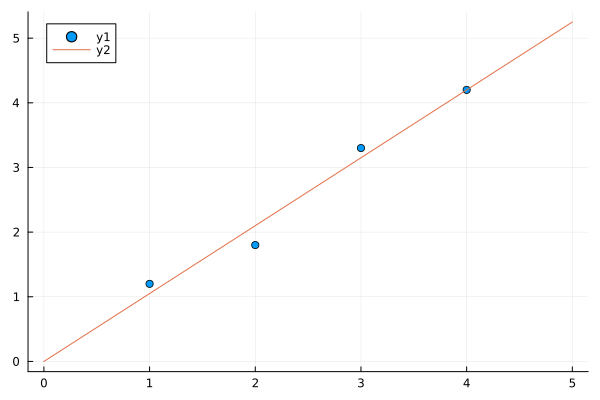

In [24]:
plot(line_xs.elements, line_ys.elements, seriestype=:scatter)
plot!([0, 5], [ref(θ, 0) * x + ref(θ, 1) for x in [0, 5]])

In [25]:
α = 0.01
revs = 1000

function gradient_descent(obj, θ)
    function f(Θ)
        gs = ∇(obj, Θ)
        map((p, g) -> p - α * g, Θ, ∇(obj, Θ))
    end
    revise(f, revs, θ)
end

gradient_descent(l2_loss(line)(line_xs, line_ys), list(1.0, 0.0))

(1.0499999696356643, 8.927484965068062e-8)

# Interlude II - Too Many Toys Make Us Hyperactive

In [26]:
smaller = nothing
larger = nothing

@assert @with_hypers(smaller, 1,
    larger, 2000,
    smaller + larger
) == 2001

@with_hypers(smaller, 1,
    larger, 2000,
    begin
        @with_hypers(smaller, 5,
            larger, 6,
            println(smaller + larger)
        )
        println(smaller + larger)
    end
)

11
2001


# 5 - Target Practice

In [27]:
α = nothing     # hyperparameter
revs = nothing  # hyperparameter

@with_hypers(α, 0.01, revs, 1000,
    gradient_descent(
        l2_loss(line)(line_xs, line_ys),
        list(0.0, 0.0)
    )
)

(1.0499993623489503, 1.8747718457656533e-6)

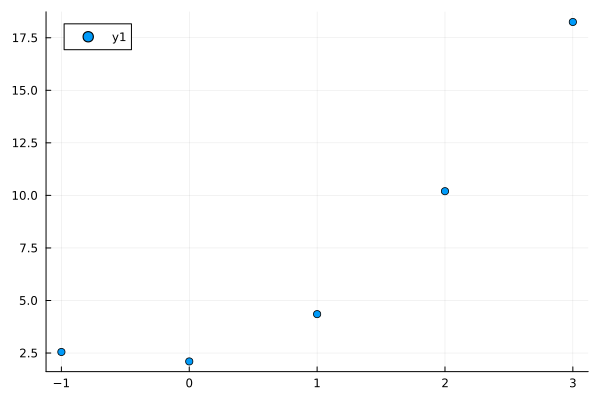

In [28]:
quad_xs = tensor([-1.0, 0.0, 1.0, 2.0, 3.0])
quad_ys = tensor([2.55, 2.1, 4.35, 10.2, 18.25])

plot(quad_xs.elements, quad_ys.elements, seriestype=:scatter)

In [29]:

# frame 102:15

quad(t) = (θ) -> ref(θ, 0) * sqr(t) + ref(θ, 1) * t + ref(θ, 2)

quad (generic function with 1 method)

In [30]:
@with_hypers(
    revs, 1000,
    α, 0.001,
    gradient_descent(
        l2_loss(quad)(quad_xs, quad_ys),
        list(0.0, 0.0, 0.0)
    )
)

(1.4787394427094362, 0.9928606519360351, 2.054642314847969)

In [31]:
plane_xs = tensor([
    [1.0, 2.05],
    [1.0, 3.0],
    [2.0, 2.0],
    [2.0, 3.91],
    [3.0, 6.13],
    [4.0, 8.09]
])

plane_ys = tensor([13.99, 15.99, 18.0, 22.4, 30.2, 37.94])

[13.99 15.99 18.0 22.4 30.2 37.94]

In [32]:

# frame 105:25

plane(t) = (θ) -> dot_product(ref(θ, 0), t) + ref(θ, 1)

plane (generic function with 1 method)

In [33]:

# frame 106:26

dot_product_1_1(w, t) = sum_1(w * t)

# frame 190:43

dot_product = ext2(dot_product_1_1, 1, 1)

(::Main.Schemish.var"#extended#15"{typeof(dot_product_1_1), Int64, Int64}) (generic function with 1 method)

In [34]:
@assert dot_product(tensor([2.0, 1.0, 7.0]), tensor([8.0, 4.0, 3.0])) == 41.0
@assert dot_product(
    tensor([1, 2]),
    tensor([tensor([1, 2]), tensor([3, 4]), tensor([5, 6])])
) == tensor([5, 11, 17])

In [35]:
@with_hypers(
    revs, 1000,
    α, 0.001,
    gradient_descent(
        l2_loss(plane)(plane_xs, plane_ys),
        list(tensor([0.0, 0.0]), 0.0)
    )
)

([3.97757644609063 2.0496557321494446], 5.786758464448078)

# 6 - An Appla a Day

In [36]:

# frame 123:24

function samples(n, s)
    list(rand(0:n-1, s)...)
end

samples (generic function with 1 method)

In [37]:
@assert trefs(tensor([5.0, 2.8, 4.2, 2.3, 7.4, 1.7, 8.1]), list(6, 0, 3, 1)) == tensor([8.1, 5.0, 2.3, 2.8])

In [38]:
batch_size = nothing  # hyperparameter

In [39]:

# frame 127:36

function sampling_obj(expectant, xs, ys)
    n = tlen(xs)
    (θ) -> let b = samples(n, batch_size)
        expectant(trefs(xs, b), trefs(ys, b))(θ)
    end
end

sampling_obj (generic function with 1 method)

In [40]:
@with_hypers(
    revs, 1000,
    α, 0.01,
    batch_size, 4,
    gradient_descent(
        sampling_obj(
            l2_loss(line), line_xs, line_ys),
        list(0.0, 0.0)
    )
)

(1.0454245880950053, -0.03911761292802285)

In [41]:
@with_hypers(
    revs, 15000,
    α, 0.001,
    batch_size, 4,
    gradient_descent(
        sampling_obj(
            l2_loss(plane), plane_xs, plane_ys),
        list(tensor([0.0, 0.0]), 0.0)
    )
)

([3.9823714315977883 1.9765850354645493], 6.170298602362728)

# 7 - The Crazy "ates"

In [42]:
# Here, I'll take a more Julia-style approach to defining the three "ates"
struct Lonely end
inflate(::Lonely) = (θ) -> map(list, θ)
deflate(::Lonely) = (Θ) -> map(first, Θ)
update(::Lonely) = (Θ, gs) -> map((p, g) -> list(ref(p, 0) - α * g), Θ, gs)


update (generic function with 1 method)

In [43]:
# the penultimate gradient-descent from frame 137:22
function gradient_descent(parameter_representation)
    inflate_fn = inflate(parameter_representation)
    deflate_fn = deflate(parameter_representation)
    update_fn = update(parameter_representation)
    (obj, θ) -> let f = (Θ) -> update_fn(Θ, (∇(obj, deflate_fn(Θ))))
        deflate_fn(revise(f, revs, inflate_fn(θ)))
    end
end


gradient_descent (generic function with 2 methods)

In [44]:
function try_plane(a_gradient_descent)
    @with_hypers(
        revs, 15000,
        α, 0.001,
        batch_size, 4,
        a_gradient_descent(
            sampling_obj(
                l2_loss(plane),
                plane_xs, plane_ys),
            list(tensor([0.0, 0.0]), 0.0)))
end

try_plane (generic function with 1 method)

In [45]:
try_plane(gradient_descent(Lonely()))

([3.985873912644485 1.9882896954926474], 6.167975967881547)

In [46]:
struct Naked end
inflate(::Naked) = (θ) -> map((p) -> p, θ)
deflate(::Naked) = (Θ) -> map((p) -> p, Θ)
update(::Naked) = (Θ, gs) -> map((p, g) -> (p - α * g), Θ, gs)

try_plane(gradient_descent(Naked()))

([3.984594357443053 1.9822661236047947], 6.173201000163386)

In [47]:

# frame 141:38

function gradient_descent(parameter_representation)
    inflate_fn = inflate(parameter_representation)
    deflate_fn = deflate(parameter_representation)
    update_fn = update(parameter_representation)
    (obj, θ) -> let f = (Θ) -> map(update_fn, Θ, ∇(obj, map(deflate_fn, Θ)))
        map(deflate_fn, revise(f, revs, map(inflate_fn, θ)))
    end
end

gradient_descent (generic function with 2 methods)

In [48]:
inflate(::Lonely) = (p) -> list(p)
deflate(::Lonely) = (P) -> first(P)
update(::Lonely) = (P, g) -> list(first(P) - α * g)

try_plane(gradient_descent(Lonely()))

([3.980142563808852 1.9687760139750778], 6.169165355888959)

In [49]:
inflate(::Naked) = (p) -> p
deflate(::Naked) = (P) -> P
update(::Naked) = (P, g) -> P - α * g

# frame 143:43
naked_gradient_descent = gradient_descent(Naked())

try_plane(naked_gradient_descent)

([3.9775510036291086 1.9740106921115808], 6.162129160373426)

# 8 - The Nearer Your Destination, the Slower You Become

In [50]:
# frame 149:21
μ = nothing  # hyperparameter; the recommendat value is usually about 0.9

In [51]:
struct Velocity end
inflate(::Velocity) = (p) -> list(p, zeroes(p))
deflate(::Velocity) = (P) -> first(P)
update(::Velocity) = (P, g) -> let v = μ *ref(P, 1) - α * g
    list(first(P) + v, v)
end

velocity_gradient_descent = gradient_descent(Velocity())

#63 (generic function with 1 method)

In [52]:
function try_plane(a_gradient_descent, a_revs)
    @with_hypers(
        revs, a_revs,
        α, 0.001,
        batch_size, 4,
        a_gradient_descent(
            sampling_obj(
                l2_loss(plane),
                plane_xs, plane_ys),
            list(tensor([0.0, 0.0]), 0.0)))
end

try_plane (generic function with 2 methods)

In [53]:
@with_hypers μ 0.9 begin
    try_plane(velocity_gradient_descent, 5000)
end

([3.9653328051715095 1.9560614164942765], 6.192297978035752)

# Interlude IV - Smooth Operator

In [54]:

# frame 155:3

function smooth(decay_rate, average, g)
    decay_rate * average + (1 - decay_rate) * g
end

smooth (generic function with 1 method)

# 9 - Be Adamant

In [55]:
β = nothing  # hyperparameter for the decay rate of the adaptive update rate

ε = 1e-8  # the "stabilizer" -- not a hyperparameter

1.0e-8

In [56]:
struct RMS end
inflate(::RMS) = (p) -> list(p, zeroes(p))
deflate(::RMS) = (P) -> first(P)
update(::RMS) = (P, g) ->
    let r = smooth(β, ref(P, 1), sqr(g))
        let α = α / (sqrt(r) + ε)
            list(first(P) - α * g, r)
        end
    end

# frame 169:29
rms_gradient_descent = gradient_descent(RMS())

#63 (generic function with 1 method)

In [57]:
function try_plane(a_gradient_descent, a_revs, an_α)
    @with_hypers(
        revs, a_revs,
        α, an_α,
        batch_size, 4,
        a_gradient_descent(
            sampling_obj(
                l2_loss(plane),
                plane_xs, plane_ys),
            list(tensor([0.0, 0.0]), 0.0)))
end

try_plane (generic function with 3 methods)

In [58]:
@with_hypers β 0.9 begin
    try_plane(rms_gradient_descent, 3000, 0.01)
end

([3.9826487894328366 1.9867271743813342], 6.155576522662351)

In [59]:
struct Adam end
inflate(::Adam) = (p) -> let v=zeroes(p); list(p, v, v) end
deflate(::Adam) = (P) -> first(P)
update(::Adam) = (P, g) ->
    let r = smooth(β, ref(P, 2), sqr(g))
        let α = α / (sqrt(r) + ε);
            v = smooth(μ, ref(P, 1), g)
            list(ref(P, 0) - α * v, v, r)
        end
    end

# frame 173:42
adam_gradient_descent = gradient_descent(Adam())

#63 (generic function with 1 method)

In [60]:
@with_hypers μ 0.85 β 0.9 begin
    try_plane(rms_gradient_descent, 1500, 0.01)
end

([3.949981992594921 1.9974000055789285], 6.164947445657001)

# Interlude V - Extensio Magnifico

In [61]:
@assert zeroes(tensor([tensor([1]), tensor([2])])) == zeroes(tensor([tensor([0]), tensor([0])]))

In [62]:

#frame 184:27

flatten = ext1(flatten_2, 2)

(::Main.Schemish.var"#extended#10"{typeof(flatten_2), Int64}) (generic function with 1 method)

In [63]:
@assert flatten_2(tensor([tensor([1]), tensor([2])])) == tensor([1, 2])
@assert flatten(tensor([tensor([tensor([1]), tensor([2])]), tensor([tensor([3]), tensor([4])])])) == tensor([tensor([1, 2]), tensor([3, 4])])

In [67]:

# frame 190:44

mul_2_1 = ext2(*, 2, 1)

(::Main.Schemish.var"#extended#15"{typeof(*), Int64, Int64}) (generic function with 1 method)

In [79]:
@assert (
    mul_2_1(
        tensor([tensor([3, 4, 5]), tensor([7, 8, 9])]),
        tensor([2, 4, 3]))
    ==
    tensor([tensor([6, 16, 15]), tensor([14, 32, 27])]))

@assert (
    mul_2_1(
        tensor([tensor([8, 1]), tensor([7, 3]), tensor([5, 4])]),
        tensor([tensor([6, 2]), tensor([4, 9]), tensor([3, 8])]))
    ==
    tensor([
        tensor([tensor([48, 2]), tensor([42, 6]), tensor([30, 8])]),
        tensor([tensor([32, 9]), tensor([28, 27]), tensor([20, 36])]),
        tensor([tensor([24, 8]), tensor([21, 24]), tensor([15, 32])])]))


# 10 - Doing the Neuron Dance